In [1]:
import os
import datetime
import pickle
import math

import scipy
import numpy  as np
import pandas as pd
import cv2

from matplotlib   import pyplot     as plt
from keras.models import load_model
from keras.models import model_from_json
from PIL          import Image

from sklearn.metrics       import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.neighbors     import NearestNeighbors

import boto3
import zipfile

import attribute_utils
import dataset_utils
import prediction_utils


Using TensorFlow backend.


In [2]:
time_start = datetime.datetime.now()
print(str(time_start))

2021-03-16 03:13:00.935826


In [3]:
#=========================================================================
# https://www.kaggle.com/muhammeddalkran/lfw-simulated-masked-face-dataset
# https://www.kaggle.com/jessicali9530/lfw-dataset
# https://www.kaggle.com/averkij/lfw-attributes
#=========================================================================

In [4]:
SHOW_MODEL = True

S3_BUCKET_NAME = "cs230project"
INPUTS_FNAME   = "lfw_datasets_and_models.zip"

PATH_INPUTS_FNAME     = "./lfw_datasets_and_models.zip" 
PATH_INPUTS           = "./lfw_datasets_and_models"

PATH_MODEL_FACENET_PRE = PATH_INPUTS + "/models/facenet/pretrained/model/facenet_keras.h5"

PATH_MODEL_FACENET_RET_ARCH    = PATH_INPUTS + "/models/facenet/retrained/encoding_facenet_arch.json"
PATH_MODEL_FACENET_RET_WEIGHTS = PATH_INPUTS + "/models/facenet/retrained/encoding_facenet_weights.h5"

PATH_MODEL_RESNET_ARCH    = PATH_INPUTS + "/models/resnet/retrained/encoding_resnet_arch.json"
PATH_MODEL_RESNET_WEIGHTS = PATH_INPUTS + "/models/resnet/retrained/encoding_resnet_weights.h5"

PATH_DATASET_BASE     = PATH_INPUTS + "/datasets/"

PATH_DATASET_BASE_MASKED   = PATH_DATASET_BASE + "/masked"
PATH_DATASET_BASE_UNMASKED = PATH_DATASET_BASE + "/unmasked"

PATH_DATASET_MASKED_TRAIN = PATH_DATASET_BASE_MASKED + "/train/"
PATH_DATASET_MASKED_VAL   = PATH_DATASET_BASE_MASKED + "/validation/"
PATH_DATASET_MASKED_TEST  = PATH_DATASET_BASE_MASKED + "/test/"

PATH_DATASET_UNMASKED_TRAIN = PATH_DATASET_BASE_UNMASKED + "/train/"
PATH_DATASET_UNMASKED_VAL   = PATH_DATASET_BASE_UNMASKED + "/validation/"
PATH_DATASET_UNMASKED_TEST  = PATH_DATASET_BASE_UNMASKED + "/test/"

PATH_DATASET_ATTRIBUTES = PATH_DATASET_BASE + "/attributes/lfw_attributes.csv"
PATH_ANALYSIS_BASE = PATH_INPUTS + "/analysis/"

PREDICT_THRESHOLD = 0.78125

# MODEL = "facenet-pretrained"
# MODEL = "facenet-retrained"
MODEL = "resnet"

REQUIRED_SIZE = (224, 224)
# REQUIRED_SIZE = (160, 160)


In [5]:
"""
Returns the cosine distance between two vectors.
"""
def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    return scipy.spatial.distance.cosine(a, b)

In [6]:
def show_image(dataset_name: str, filename: str):
    img = dataset_utils.extract_face(dataset_name + filename)
    img = np.squeeze(img, axis=0)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [7]:
def get_embeddings(dataset, facenet_model):
    ret = np.empty((len(dataset), 128))
    for i, face in enumerate(dataset):
        ret[i] = facenet_model.predict(face)
        if (i % 1000 == 0):
            print(i)
    return ret

In [8]:
# dataset_utils.download_s3_file(S3_BUCKET_NAME, INPUTS_FNAME, PATH_INPUTS_FNAME)

In [9]:
# dataset_utils.extract_zipfile(PATH_INPUTS_FNAME, PATH_INPUTS, "./")

In [10]:
print("[INFO] Loading attributes...", end=" ")
df_attributes = pd.read_csv(PATH_DATASET_ATTRIBUTES, sep=",", header=0)
df_attributes = df_attributes[(df_attributes.person != "Larry Coker")]
print("DONE.")

print("[INFO] Setting attribute 'Gender'...", end=" ")
df_attributes = attribute_utils.fix_attribute_gender(df_attributes)
print("DONE.")

print("[INFO] Setting attribute 'Race'...", end=" ")
df_attributes = attribute_utils.fix_attribute_race(df_attributes)
print("DONE.")

print("[INFO] Setting attribute 'Age'...", end=" ")
df_attributes = attribute_utils.fix_attribute_age(df_attributes)
print("DONE.")

[INFO] Loading attributes... DONE.
[INFO] Setting attribute 'Gender'... DONE.
[INFO] Setting attribute 'Race'... DONE.
[INFO] Setting attribute 'Age'... DONE.


In [11]:
plt.rc("font", size=14)
plt.rc("axes", titlesize=24)

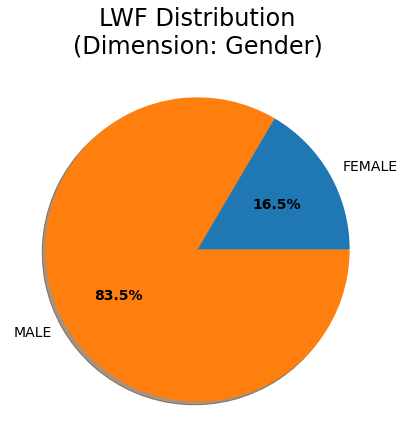

In [14]:
df_genders = df_attributes[["Gender"]].groupby(["Gender"]).size().reset_index(name = "count")

labels     = df_genders["Gender"]
values     = df_genders["count"]

fig, ax                  = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", shadow=True)
ax.set_title("LWF Distribution\n(Dimension: Gender)")

plt.setp(autotexts, size=14, weight="bold")

plt.savefig(PATH_ANALYSIS_BASE + "lfw_gender.jpg")
plt.show()

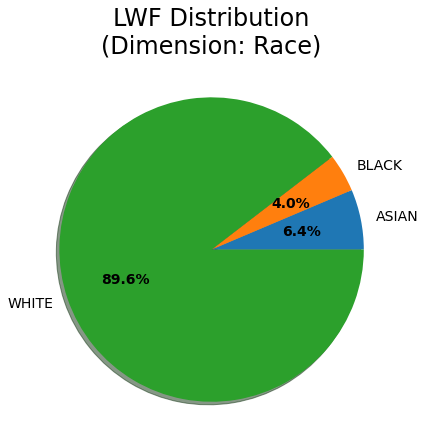

In [15]:
df_races = df_attributes[["Race"]].groupby(["Race"]).size().reset_index(name = "count")

labels     = df_races["Race"]
values     = df_races["count"]

fig, ax                  = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", shadow=True)

plt.setp(autotexts, size=14, weight="bold")
ax.set_title("LWF Distribution\n(Dimension: Race)")

plt.setp(autotexts, size=14, weight="bold")

plt.savefig(PATH_ANALYSIS_BASE + "lfw_race.jpg")
plt.show()

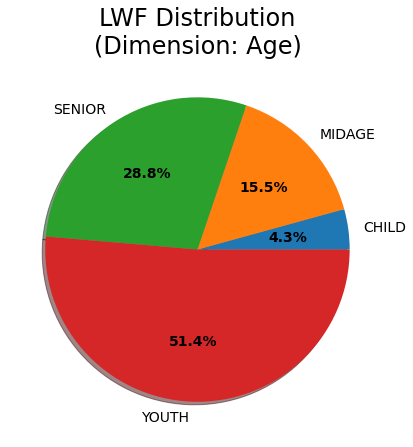

In [16]:
df_ages = df_attributes[["Age"]].groupby(["Age"]).size().reset_index(name = "count")

labels     = df_ages["Age"]
values     = df_ages["count"]

fig, ax                  = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", shadow=True)

ax.set_title("LWF Distribution\n(Dimension: Age)")

plt.setp(autotexts, size=14, weight="bold")

plt.savefig(PATH_ANALYSIS_BASE + "lfw_age.jpg")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


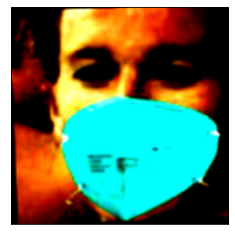

In [17]:
show_image(PATH_DATASET_MASKED_TEST, "/Aaron_Peirsol/Aaron_Peirsol_0004.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


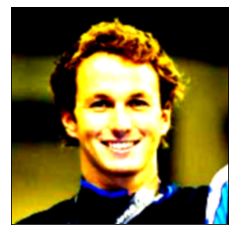

In [18]:
show_image(PATH_DATASET_UNMASKED_VAL, "/Aaron_Peirsol/Aaron_Peirsol_0003.jpg")

In [19]:
print("[INFO] Loading masked training dataset...")
train_masked_x, train_masked_y = dataset_utils.load_dataset(PATH_DATASET_MASKED_TRAIN, REQUIRED_SIZE)
print(train_masked_x.shape, train_masked_y.shape)

[INFO] Loading masked training dataset...
[DEBUG] Loading dataset... ./lfw_datasets_and_models/datasets//masked/train/
i=0; subdir=Juan_Pablo_Montoya
i=500; subdir=John_Geoghan
i=1000; subdir=Raag_Singhal
i=1500; subdir=Thomas_Malchow
i=2000; subdir=Joey_Mantia
i=2500; subdir=Mohammad_Aktar
i=3000; subdir=Blythe_Danner
i=3500; subdir=Mark_Sisk
i=4000; subdir=Darren_Clarke
i=4500; subdir=Lewis_Booth
i=5000; subdir=Lawrence_Foley
i=5500; subdir=Michalis_Chrisohoides
(10559, 1, 224, 224, 3) (10559,)


In [20]:
print("[INFO] Loading unmasked training dataset...")
train_unmasked_x, train_unmasked_y = dataset_utils.load_dataset(PATH_DATASET_UNMASKED_TRAIN, REQUIRED_SIZE)
print(train_unmasked_x.shape, train_unmasked_y.shape)

[INFO] Loading unmasked training dataset...
[DEBUG] Loading dataset... ./lfw_datasets_and_models/datasets//unmasked/train/
i=0; subdir=Juan_Pablo_Montoya
i=500; subdir=Dai_Bachtiar
i=1000; subdir=Samira_Makhmalbaf
i=1500; subdir=Torri_Edwards
i=2000; subdir=Bobby_Robson
i=2500; subdir=Michael_Shelby
i=3000; subdir=Anatoliy_Kinakh
i=3500; subdir=Mary_Matalin
i=4000; subdir=Steve_Rush
i=4500; subdir=Mariana_Ohata
i=5000; subdir=Bustam_A_Zedan_Aljanabi
i=5500; subdir=Martin_Sheen
(11429, 1, 224, 224, 3) (11429,)


In [21]:
print("[INFO] Loading masked validation dataset...")
val_masked_x, val_masked_y = dataset_utils.load_dataset(PATH_DATASET_MASKED_VAL, REQUIRED_SIZE)
print(val_masked_x.shape, val_masked_y.shape)

[INFO] Loading masked validation dataset...
[DEBUG] Loading dataset... ./lfw_datasets_and_models/datasets//masked/validation/
i=0; subdir=Juan_Pablo_Montoya
i=500; subdir=Larry_Bowa
i=1000; subdir=Magdalena_Maleeva
i=1500; subdir=Mel_Gibson
(1664, 1, 224, 224, 3) (1664,)


In [22]:
print("[INFO] Loading unmasked validation dataset...")
val_unmasked_x, val_unmasked_y = dataset_utils.load_dataset(PATH_DATASET_UNMASKED_VAL, REQUIRED_SIZE)
print(val_unmasked_x.shape, val_unmasked_y.shape)

[INFO] Loading unmasked validation dataset...
[DEBUG] Loading dataset... ./lfw_datasets_and_models/datasets//unmasked/validation/
i=0; subdir=Juan_Pablo_Montoya
i=500; subdir=Alan_Ball
i=1000; subdir=Richard_Sambrook
i=1500; subdir=Arnold_Schwarzenegger
(1679, 1, 224, 224, 3) (1679,)


In [23]:
print("[INFO] Loading masked test dataset...")
test_masked_x, test_masked_y = dataset_utils.load_dataset(PATH_DATASET_MASKED_TEST, REQUIRED_SIZE)
print(test_masked_x.shape, test_masked_y.shape)

[INFO] Loading masked test dataset...
[DEBUG] Loading dataset... ./lfw_datasets_and_models/datasets//masked/test/
i=0; subdir=Juan_Pablo_Montoya
i=500; subdir=Mahmoud_Abbas
(887, 1, 224, 224, 3) (887,)


In [24]:
print("[INFO] Loading unmasked test dataset...")
test_unmasked_x, test_unmasked_y = dataset_utils.load_dataset(PATH_DATASET_UNMASKED_TEST, REQUIRED_SIZE)
print(test_unmasked_x.shape, test_unmasked_y.shape)

[INFO] Loading unmasked test dataset...
[DEBUG] Loading dataset... ./lfw_datasets_and_models/datasets//unmasked/test/
i=0; subdir=Juan_Pablo_Montoya
i=500; subdir=Joe_Nichols
(900, 1, 224, 224, 3) (900,)


In [25]:
# combine masked and unmasked datasets
train_x = np.concatenate((train_masked_x, train_unmasked_x), axis=0)
train_y = np.concatenate((train_masked_y, train_unmasked_y), axis=0)

val_x = np.concatenate((val_masked_x, val_unmasked_x), axis=0)
val_y = np.concatenate((val_masked_y, val_unmasked_y), axis=0)

test_x = np.concatenate((test_masked_x, test_unmasked_x), axis=0)
test_y = np.concatenate((test_masked_y, test_unmasked_y), axis=0)

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(21988, 1, 224, 224, 3) (21988,)
(3343, 1, 224, 224, 3) (3343,)
(1787, 1, 224, 224, 3) (1787,)


In [26]:
total_masked   = train_masked_x.shape[0]   + val_masked_x.shape[0]   + test_masked_x.shape[0]
total_unmasked = train_unmasked_x.shape[0] + val_unmasked_x.shape[0] + test_unmasked_x.shape[0]

total = total_masked + total_unmasked

print("Masked split:   [train / val / test] = [%d / %d / %d]" % (train_masked_x.shape[0], val_masked_x.shape[0], test_masked_x.shape[0]))
print("UnMasked split: [train / val / test] = [%d / %d / %d]" % (train_unmasked_x.shape[0], val_unmasked_x.shape[0], test_unmasked_x.shape[0]))
print("Total split:    [train / val / test] = [%d / %d / %d]" % (train_x.shape[0], val_x.shape[0], test_x.shape[0]))

print("")

print("Masked split:   [train / val / test] = [%4.2f%% / %4.2f%% / %4.2f%%]" % (
    train_masked_x.shape[0] / total_masked * 100,
    val_masked_x.shape[0]   / total_masked * 100,
    test_masked_x.shape[0]  / total_masked * 100))

print("Unmasked split: [train / val / test] = [%4.2f%% / %4.2f%% / %4.2f%%]" % (
    train_unmasked_x.shape[0] / total_unmasked * 100,
    val_unmasked_x.shape[0]   / total_unmasked * 100,
    test_unmasked_x.shape[0]  / total_unmasked * 100))

print("Total split:    [train / val / test] = [%4.2f%% / %4.2f%% / %4.2f%%]" % (
    train_x.shape[0] / total * 100,
    val_x.shape[0]   / total * 100,
    test_x.shape[0]  / total * 100))


Masked split:   [train / val / test] = [10559 / 1664 / 887]
UnMasked split: [train / val / test] = [11429 / 1679 / 900]
Total split:    [train / val / test] = [21988 / 3343 / 1787]

Masked split:   [train / val / test] = [80.54% / 12.69% / 6.77%]
Unmasked split: [train / val / test] = [81.59% / 11.99% / 6.42%]
Total split:    [train / val / test] = [81.08% / 12.33% / 6.59%]


In [27]:
def load_model_arch_weights(path_model_arch, path_model_weights):
    with open(path_model_arch, "r") as json_file:
        model_arch = json_file.read()

    #load the model architecture 
    model = model_from_json(model_arch)

    #load the model weights
    model.load_weights(path_model_weights)

    return model

In [28]:
def load_model_():
    ret = None
    if (MODEL == "facenet-pretrained"):
        print("[INFO] Loading Facenet pre-trained model...", PATH_MODEL_FACENET_PRE)
        ret = load_model(PATH_MODEL_FACENET_PRE)
        print('[INFO] Loaded Model')
    elif (MODEL == "facenet-retrained"):
        ret = load_model_arch_weights(PATH_MODEL_FACENET_RET_ARCH, PATH_MODEL_FACENET_RET_WEIGHTS)
    elif (MODEL == "resnet"):
        ret = load_model_arch_weights(PATH_MODEL_RESNET_ARCH, PATH_MODEL_RESNET_WEIGHTS)

    if (SHOW_MODEL):
        ret.summary()

    return ret

In [29]:
facenet_model = load_model_()














_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_encoding_input (Input (None, 224, 224, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 128)               23850496  
Total params: 23,850,496
Trainable params: 304,512
Non-trainable params: 23,545,984
_________________________________________________________________


In [30]:
print("[INFO] Generating embeddings for training set...", end=" ")
train_emd_x = get_embeddings(train_x, facenet_model)
print("DONE.")
print(train_emd_x.shape)

[INFO] Generating embeddings for training set... 0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
DONE.
(21988, 128)


In [31]:
print("[INFO] Generating embeddings for validation set...", end=" ")
val_emd_x = get_embeddings(val_x, facenet_model)
print("DONE.")
print(val_emd_x.shape)

[INFO] Generating embeddings for validation set... 0
1000
2000
3000
DONE.
(3343, 128)


In [32]:
print("[INFO] Generating embeddings for test set...", end=" ")
test_emd_x = get_embeddings(test_x, facenet_model)
print("DONE.")
print(test_emd_x.shape)

[INFO] Generating embeddings for test set... 0
1000
DONE.
(1787, 128)


In [33]:
print("[INFO] Label encoding...")
print("Dataset: train=%d, test=%d" % (train_emd_x.shape[0], test_emd_x.shape[0]))

# normalize input vectors
in_encoder       = Normalizer(norm='l2')
train_emd_norm_x = in_encoder.transform(train_emd_x)
val_emd_norm_x   = in_encoder.transform(val_emd_x)
test_emd_norm_x  = in_encoder.transform(test_emd_x)

# label encode targets
out_encoder = LabelEncoder()
encoder_arr = np.append (train_y, ['Ben_Affleck', 'Ben_Curtis', 'Ben_Howland', 'Benazir_Bhutto', 'Benjamin_Netanyahu', 'Bernard_Landry', 'Bernard_Law', 'Bertie_Ahern'])
out_encoder.fit(encoder_arr)

[INFO] Label encoding...
Dataset: train=21988, test=1787


LabelEncoder()

In [34]:
df_attributes["Person"] = df_attributes.apply(attribute_utils.get_attribute_person, axis=1)
df_attributes["Person"] = out_encoder.transform(df_attributes["Person"])
df_attributes = df_attributes[["Person", "Gender", "Race", "Age"]]
# df_attributes.set_index("Person")
df_attributes

,Person,Gender,Race,Age
0,2,MALE,WHITE,CHILD
1,3,MALE,WHITE,MIDAGE
2,4,MALE,WHITE,MIDAGE
3,5,MALE,WHITE,YOUTH
4,5,MALE,WHITE,YOUTH
...,...,...,...,...
13138,5743,FEMALE,ASIAN,CHILD
13139,5744,MALE,BLACK,MIDAGE
13140,5745,FEMALE,WHITE,SENIOR
13141,5746,MALE,WHITE,SENIOR


In [35]:
print("[INFO] Encoding training set with fitted encoder...")
train_enc_y = out_encoder.transform(train_y)

[INFO] Encoding training set with fitted encoder...


In [36]:
print("[INFO] Encoding validation set with fitted encoder...")
val_enc_y = out_encoder.transform(val_y)

[INFO] Encoding validation set with fitted encoder...


In [37]:
print("[INFO] Encoding test set with fitted encoder...")
test_enc_y = out_encoder.transform(test_y)

[INFO] Encoding test set with fitted encoder...


In [38]:
print("[INFO] Training NN model on training set...", end=" ")
neighbors  = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_emd_norm_x)
print("DONE.")

[INFO] Training NN model on training set... DONE.


In [39]:
print("[INFO] Testing model on training set...", end=" ")
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, train_emd_norm_x, train_enc_y)
print("DONE.")

[INFO] Testing model on training set... DONE.


In [40]:
print("Training set performance:")
prediction_utils.show_metrics(result_predict)

Training set performance:
    total:  21988 (100.00 %)
    TP:     21986 ( 99.99 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.01 %)
MALE:
    total:  18460 (100.00 %)
    TP:     18458 ( 99.99 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.01 %)
FEMALE:
    total:   3528 (100.00 %)
    TP:      3528 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
WHITE:
    total:  19568 (100.00 %)
    TP:     19566 ( 99.99 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.01 %)
ASIAN:
    total:   1491 (100.00 %)
    TP:      1491 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
BLACK:
    total:    929 (100.00 %)
    TP:       929 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)


In [41]:
print("[INFO] Testing model on validation set...", end=" ")
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, val_emd_norm_x, val_enc_y)
print("DONE.")

[INFO] Testing model on validation set... DONE.


In [42]:
print("Validation set performance:")
prediction_utils.show_metrics(result_predict)

Validation set performance:
    total:   3343 (100.00 %)
    TP:       781 ( 23.36 %)
    FN:         0 (  0.00 %)
    FP:      2562 ( 76.64 %)
MALE:
    total:   2706 (100.00 %)
    TP:       632 ( 23.36 %)
    FN:         0 (  0.00 %)
    FP:      2074 ( 76.64 %)
FEMALE:
    total:    637 (100.00 %)
    TP:       149 ( 23.39 %)
    FN:         0 (  0.00 %)
    FP:       488 ( 76.61 %)
WHITE:
    total:   3030 (100.00 %)
    TP:       684 ( 22.57 %)
    FN:         0 (  0.00 %)
    FP:      2346 ( 77.43 %)
ASIAN:
    total:    166 (100.00 %)
    TP:        45 ( 27.11 %)
    FN:         0 (  0.00 %)
    FP:       121 ( 72.89 %)
BLACK:
    total:    147 (100.00 %)
    TP:        52 ( 35.37 %)
    FN:         0 (  0.00 %)
    FP:        95 ( 64.63 %)


In [43]:
print("[INFO] Testing model on test set...", end=" ")
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, test_emd_norm_x, test_enc_y)
print("DONE.")

[INFO] Testing model on test set... DONE.


In [44]:
print("Test set performance:")
prediction_utils.show_metrics(result_predict)

Test set performance:
    total:   1787 (100.00 %)
    TP:         1 (  0.06 %)
    FN:         0 (  0.00 %)
    FP:      1786 ( 99.94 %)
MALE:
    total:   1446 (100.00 %)
    TP:         1 (  0.07 %)
    FN:         0 (  0.00 %)
    FP:      1445 ( 99.93 %)
FEMALE:
    total:    341 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       341 (100.00 %)
WHITE:
    total:   1667 (100.00 %)
    TP:         1 (  0.06 %)
    FN:         0 (  0.00 %)
    FP:      1666 ( 99.94 %)
ASIAN:
    total:     76 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        76 (100.00 %)
BLACK:
    total:     44 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        44 (100.00 %)


In [45]:
print("[INFO] Testing model on training set (masked)...")
train_masked_len = train_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, train_emd_norm_x[:train_masked_len,], train_enc_y[:train_masked_len,])
print("DONE.")

[INFO] Testing model on training set (masked)...
DONE.


In [46]:
print("Training set performance (masked):")
prediction_utils.show_metrics(result_predict)

Training set performance (masked):
    total:  10559 (100.00 %)
    TP:     10557 ( 99.98 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.02 %)
MALE:
    total:   8871 (100.00 %)
    TP:      8869 ( 99.98 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.02 %)
FEMALE:
    total:   1688 (100.00 %)
    TP:      1688 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
WHITE:
    total:   9404 (100.00 %)
    TP:      9402 ( 99.98 %)
    FN:         0 (  0.00 %)
    FP:         2 (  0.02 %)
ASIAN:
    total:    720 (100.00 %)
    TP:       720 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
BLACK:
    total:    435 (100.00 %)
    TP:       435 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)


In [47]:
print("[INFO] Testing model on training set (unmasked)...")
train_masked_len = train_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, train_emd_norm_x[train_masked_len:,], train_enc_y[train_masked_len:,])
print("DONE.")

[INFO] Testing model on training set (unmasked)...
DONE.


In [48]:
print("Training set performance (unmasked):")
prediction_utils.show_metrics(result_predict)

Training set performance (unmasked):
    total:  11429 (100.00 %)
    TP:     11429 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
MALE:
    total:   9589 (100.00 %)
    TP:      9589 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
FEMALE:
    total:   1840 (100.00 %)
    TP:      1840 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
WHITE:
    total:  10164 (100.00 %)
    TP:     10164 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
ASIAN:
    total:    771 (100.00 %)
    TP:       771 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)
BLACK:
    total:    494 (100.00 %)
    TP:       494 (100.00 %)
    FN:         0 (  0.00 %)
    FP:         0 (  0.00 %)


In [49]:
print("[INFO] Testing model on validation set (masked)...")
val_masked_len = val_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, val_emd_norm_x[:val_masked_len,], val_enc_y[:val_masked_len,])
print("DONE.")

[INFO] Testing model on validation set (masked)...
DONE.


In [50]:
print("Validation set performance (masked):")
prediction_utils.show_metrics(result_predict)

Validation set performance (masked):
    total:   1664 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:      1664 (100.00 %)
MALE:
    total:   1347 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:      1347 (100.00 %)
FEMALE:
    total:    317 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       317 (100.00 %)
WHITE:
    total:   1508 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:      1508 (100.00 %)
ASIAN:
    total:     83 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        83 (100.00 %)
BLACK:
    total:     73 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        73 (100.00 %)


In [51]:
print("[INFO] Testing model on validation set (unmasked)...")
val_masked_len = val_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, val_emd_norm_x[val_masked_len:,], val_enc_y[val_masked_len:,])
print("DONE.")

[INFO] Testing model on validation set (unmasked)...
DONE.


In [52]:
print("Validation set performance (unmasked):")
prediction_utils.show_metrics(result_predict)

Validation set performance (unmasked):
    total:   1679 (100.00 %)
    TP:       781 ( 46.52 %)
    FN:         0 (  0.00 %)
    FP:       898 ( 53.48 %)
MALE:
    total:   1359 (100.00 %)
    TP:       632 ( 46.50 %)
    FN:         0 (  0.00 %)
    FP:       727 ( 53.50 %)
FEMALE:
    total:    320 (100.00 %)
    TP:       149 ( 46.56 %)
    FN:         0 (  0.00 %)
    FP:       171 ( 53.44 %)
WHITE:
    total:   1522 (100.00 %)
    TP:       684 ( 44.94 %)
    FN:         0 (  0.00 %)
    FP:       838 ( 55.06 %)
ASIAN:
    total:     83 (100.00 %)
    TP:        45 ( 54.22 %)
    FN:         0 (  0.00 %)
    FP:        38 ( 45.78 %)
BLACK:
    total:     74 (100.00 %)
    TP:        52 ( 70.27 %)
    FN:         0 (  0.00 %)
    FP:        22 ( 29.73 %)


In [53]:
print("[INFO] Testing model on test set (masked)...")
test_masked_len = test_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, test_emd_norm_x[:test_masked_len,], test_enc_y[:test_masked_len,])
print("DONE.")

[INFO] Testing model on test set (masked)...
DONE.


In [54]:
print("Test set performance (masked):")
prediction_utils.show_metrics(result_predict)

Test set performance (masked):
    total:    887 (100.00 %)
    TP:         1 (  0.11 %)
    FN:         0 (  0.00 %)
    FP:       886 ( 99.89 %)
MALE:
    total:    717 (100.00 %)
    TP:         1 (  0.14 %)
    FN:         0 (  0.00 %)
    FP:       716 ( 99.86 %)
FEMALE:
    total:    170 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       170 (100.00 %)
WHITE:
    total:    827 (100.00 %)
    TP:         1 (  0.12 %)
    FN:         0 (  0.00 %)
    FP:       826 ( 99.88 %)
ASIAN:
    total:     38 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        38 (100.00 %)
BLACK:
    total:     22 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        22 (100.00 %)


In [55]:
print("[INFO] Testing model on test set (unmasked)...")
test_masked_len = test_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x, train_enc_y, test_emd_norm_x[test_masked_len:,], test_enc_y[test_masked_len:,])
print("DONE.")

[INFO] Testing model on test set (unmasked)...
DONE.


In [56]:
print("Test set performance (unmasked):")
prediction_utils.show_metrics(result_predict)

Test set performance (unmasked):
    total:    900 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       900 (100.00 %)
MALE:
    total:    729 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       729 (100.00 %)
FEMALE:
    total:    171 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       171 (100.00 %)
WHITE:
    total:    840 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       840 (100.00 %)
ASIAN:
    total:     38 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        38 (100.00 %)
BLACK:
    total:     22 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        22 (100.00 %)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO]: Predicting some samples from validation set...
                   input_label                   output_label   distance
                   ===========                   ============   ========
            Juan_Pablo_Montoya                    Julia_Glass    0.01150


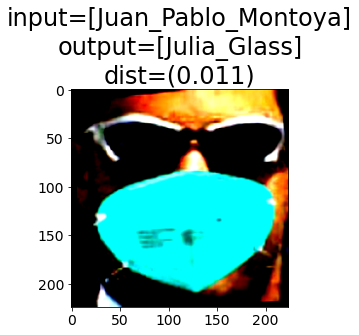

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              Janet_Napolitano                   John_Eastman    0.00538


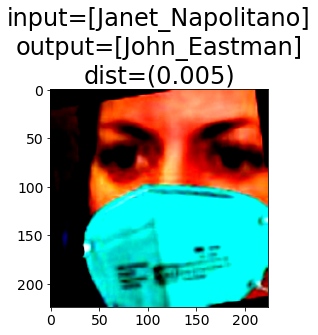

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


             Dale_Earnhardt_Jr                  Ricardo_Lagos    0.00487


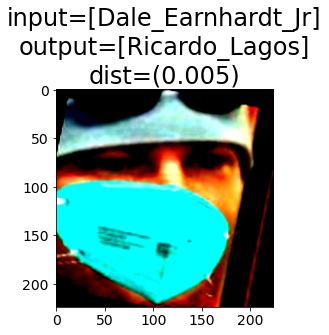

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              Dennis_Kozlowski          Dominique_de_Villepin    0.00321


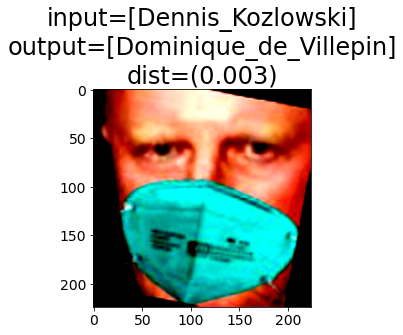

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              Alejandro_Toledo                 Vassilis_Xiros    0.00559


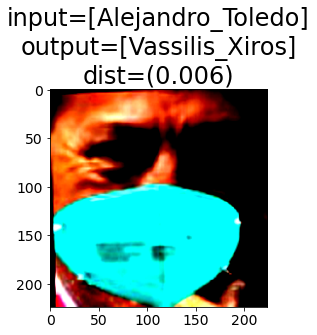

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                   Rita_Moreno              Maria_Shkolnikova    0.00549


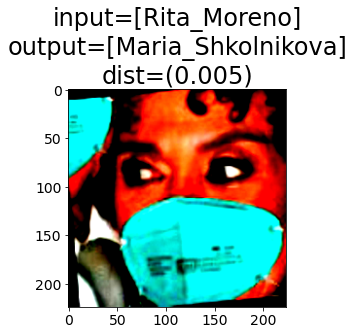

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


               Ibrahim_Jaafari         Guangdong_Ou_Guangyuan    0.00633


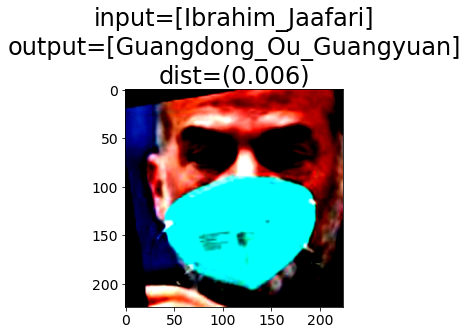

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                 Sergei_Ivanov                    Helen_Clark    0.00555


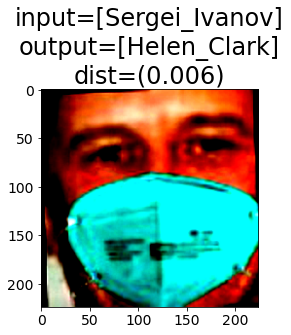

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                 Tony_Shalhoub      Fernando_Henrique_Cardoso    0.00726


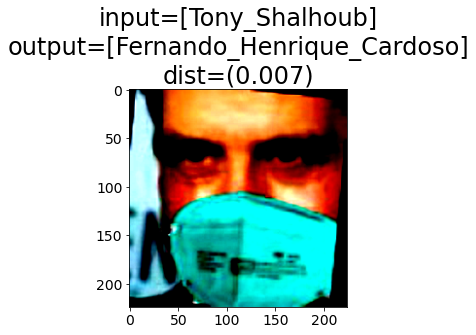

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              Sheila_Wellstone                 Jennifer_Lopez    0.00476


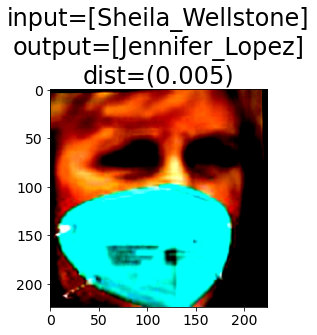

In [57]:
print("[INFO]: Predicting some samples from validation set...")
print("%30s %30s %10s" % ("input_label", "output_label", "distance"))
print("%30s %30s %10s" % ("===========", "============", "========"))
for i in range(0,10):
    emd = val_emd_norm_x[i]
    lbl = val_enc_y[i]
    prs = out_encoder.inverse_transform([lbl])

    print("%30s" % (prs[0]), end=" ")
    distances, indices = neighbors.kneighbors([emd])

    if ((indices is None) or (len(indices) <= 0)):
        print("NOT FOUND.")
        continue

    lbl_found = train_enc_y[indices[0][0]]
    prs_found = out_encoder.inverse_transform([lbl_found])[0]
    print("%30s %10.5f" % (prs_found, distances[0]))

    face = np.squeeze(val_x[i], axis=0)
    plt.imshow(face)
    title = 'input=[%s]\noutput=[%s]\ndist=(%.3f)' % (prs[0], prs_found, distances[0])
    plt.title(title)
    plt.show()
    

In [58]:
print("[INFO] Training NN model on unmasked training set...", end=" ")
len_masked          = train_masked_x.shape[0]
neighbors_unmasked  = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_emd_norm_x[len_masked:,])
print("DONE.")

[INFO] Training NN model on unmasked training set... DONE.


In [59]:
print("[INFO] Testing model on validation set (masked vs unmasked)...")
val_masked_len = val_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors_unmasked, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x[len_masked:,], train_enc_y[len_masked:,], val_emd_norm_x[:val_masked_len,], val_enc_y[:val_masked_len,])
print("DONE.")

[INFO] Testing model on validation set (masked vs unmasked)...
DONE.


In [60]:
print("Validation set performance (masked vs unmasked):")
prediction_utils.show_metrics(result_predict)

Validation set performance (masked vs unmasked):
    total:   1664 (100.00 %)
    TP:         1 (  0.06 %)
    FN:         0 (  0.00 %)
    FP:      1663 ( 99.94 %)
MALE:
    total:   1347 (100.00 %)
    TP:         1 (  0.07 %)
    FN:         0 (  0.00 %)
    FP:      1346 ( 99.93 %)
FEMALE:
    total:    317 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       317 (100.00 %)
WHITE:
    total:   1508 (100.00 %)
    TP:         1 (  0.07 %)
    FN:         0 (  0.00 %)
    FP:      1507 ( 99.93 %)
ASIAN:
    total:     83 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        83 (100.00 %)
BLACK:
    total:     73 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        73 (100.00 %)


In [61]:
print("[INFO] Testing model on test set (masked vs unmasked)...")
test_masked_len = test_masked_x.shape[0]
result_predict = prediction_utils.predict(neighbors_unmasked, PREDICT_THRESHOLD, df_attributes, train_emd_norm_x[len_masked:,], train_enc_y[len_masked:,], test_emd_norm_x[:test_masked_len,], test_enc_y[:test_masked_len,])
print("DONE.")

[INFO] Testing model on test set (masked vs unmasked)...
DONE.


In [62]:
print("Test set performance (masked vs unmasked):")
prediction_utils.show_metrics(result_predict)

Test set performance (masked vs unmasked):
    total:    887 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       887 (100.00 %)
MALE:
    total:    717 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       717 (100.00 %)
FEMALE:
    total:    170 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       170 (100.00 %)
WHITE:
    total:    827 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:       827 (100.00 %)
ASIAN:
    total:     38 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        38 (100.00 %)
BLACK:
    total:     22 (100.00 %)
    TP:         0 (  0.00 %)
    FN:         0 (  0.00 %)
    FP:        22 (100.00 %)


In [63]:
time_end = datetime.datetime.now()
print(str(time_end))

time_diff = time_end - time_start
print("duration: ", time_diff)

2021-03-16 04:05:51.714501
duration:  0:52:50.778675
